<a href="https://colab.research.google.com/github/raulFuzita/cct_ai/blob/CA3/raul_macedo_fuzita_AI_DV_DP_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
#@title Import Necessary Resources


import pandas as pd
import numpy as np

df_fire_officers = pd.read_csv("https://raw.githubusercontent.com/raulFuzita/cct_ai/CA3/fire_station.csv")
df_rooms = pd.read_csv("https://raw.githubusercontent.com/raulFuzita/cct_ai/CA3/rooms_location.csv")

df_fire_officers.columns = df_fire_officers.columns.str.lower()
df_rooms.columns = df_rooms.columns.str.lower()

In [152]:
#@title Constraint Satisfaction Problem (CSP)

# csp.py
# From Classic Computer Science Problems in Python Chapter 3
# Copyright 2018 David Kopec
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type


# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    # The variables that the constraint is between
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    # Must be overridden by subclasses
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...


# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid
class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables: List[V] = variables # variables to be constrained
        self.domains: Dict[V, List[D]] = domains # domain of each variable
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # get all variables in the CSP but not in the assignment
        unassigned: List[V] = [v for v in self.variables if v not in assignment]

        # get the every possible domain value of the first unassigned variable
        first: V = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                # if we didn't find the result, we will end up backtracking
                if result is not None:
                    return result
        return None

In [153]:
#@title Conversor from DataFrame into Constraint Dictionary


def split(col):
    if type(col) == str and ';' in col:
        return [item.strip() for item in col.split(';')]  
    else: 
        return [col] if col != None else col

def df_to_constraintdict(df):
    df = df.where(df.notnull(), None)
    tmp_dict = dict()
    for index, row in df.iterrows():

        tmp_dict[row['officers']] = {
            'yes': split(row['yes']),
            'no': split(row['no']),
            'office': row['office'],
            'no_office_adjacent': split(row['no_office_adjacent']),
        }
    return tmp_dict

In [457]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

class RoomsGraph:

    def __init__(self, rooms: dict=dict(), components: dict=dict(), figsize: tuple=(12, 8)) -> None:
        self.colors = []
        self.plt = plt
        self.plt.rcParams["figure.figsize"]=figsize
        fig, ax = self.plt.subplots()
        self.fig = fig
        self.ax = ax
        self.setGrid(True)
        self.addRooms(rooms)
        self.addComponents(components)
        self.setComponentSize(14)
        self.setTite('Rooms\n')

    def _RGBdecToPerc(self, r, g=0, b=0, a=None, output=None) -> tuple or list: 
        if r > 255: r = 255
        if g > 255: g = 255
        if b > 255: b = 255
        perc = (round(r/255,2),round(g/255,2),round(b/255,2))
        if a != None: perc = perc + (a if a <= 1 else 1,)
        if output==list: return list(perc)
        else: return perc

    def _color(self, room: int) -> tuple:
        op = room % 4
        room *= 5
        ch = room if room <= 255 else room % 255
        if op == 1: return self._RGBdecToPerc(31+ch, 119+ch, 180+ch) # blue
        if op == 2: return self._RGBdecToPerc(255+ch, 127+ch, 14+ch) # orange
        if op == 3: return self._RGBdecToPerc(44+ch, 160+ch, 44+ch)  # green
        if op == 0: return self._RGBdecToPerc(214+ch, 39+ch, 40+ch)  # red

    def setGrid(self, flag: bool):
        self.ax.grid(flag)
        return self

    def setTite(self, title: str, fontsize: int=20):
        self.ax.set_title(title, fontsize=fontsize)
        return self

    def setXLabel(self, label: str, labelsize: int=20):
        self.plt.rc('axes', labelsize=labelsize)
        self.ax.set_xlabel(label)
        return self

    def setYLabel(self, label: str, labelsize: int=20):
        self.plt.rc('axes', labelsize=labelsize)
        self.ax.set_ylabel(label)
        return self

    def addRooms(self, rooms: dict):
        self.rooms = rooms
        for room in rooms:
            self.colors.append(self._color(room))
        return self

    def addComponents(self, components: dict):
        self.components = components
        return self

    def setComponentSize(self, fontsize: int):
        self.compSize = fontsize
        return self

    def _yieldComponents(self) -> None:
        roomfreq = dict()
        for i in self.components:
            num = self.components[i]
            roomfreq[num] = roomfreq[num]+1 if num in roomfreq else 1
            x = (self.rooms[num]['x']+5)
            y = (self.rooms[num]['y']+self.rooms[num]['height'])
            y -= (roomfreq[num] * 6)
            self.ax.annotate(i, (x, y), fontsize=self.compSize)

    def _yieldRooms(self) -> None:
        count = 0
        for i in self.rooms:
            room = self.rooms[i]
            self.ax.broken_barh(
                [(room['x'], room['width'])], 
                (room['y'], room['height']), 
                facecolors=self.colors[count])
            count+=1

    def _yieldLegend(self) -> None:
        legends = list()
        for i in range(len(self.rooms)):
            legends.append(mpatches.Patch(color=self.colors[i], label=(i+1)))
        plt.legend(handles=legends)

    def show(self) -> None:
        self._yieldRooms()
        self._yieldLegend()
        self._yieldComponents()
        self.plt.show()

In [425]:
from typing import Dict, List, Optional

class FireStation(Constraint[str, int]):
    def __init__(self, officer: str, officers: List[str], constraints: Dict[str, object]) -> None:
        super().__init__(officers)
        self.officer = officer
        self.officers: List[str] = officers
        self.constraints: Dict[str, object] = constraints

    def validate(self, assignment: Dict[int, str]) -> bool:
        for i in self.constraints:
            constraint = self.constraints[self.officer]
            notwork = constraint['no']
            work = constraint['yes']
            mustbeat = constraint['office']
            noadjoffice = constraint['no_office_adjacent']
            if notwork != None:
                for j in notwork:
                    if self.officer in assignment and j in assignment:
                        if assignment[self.officer] == assignment[j]:
                            return False
            if work != None:
                for j in work:
                    if self.officer in assignment and j in assignment:
                        if assignment[self.officer] != assignment[j]:
                            return False
            if mustbeat != None:
                if self.officer in assignment: 
                    if assignment[self.officer] != mustbeat:
                        return False
            if noadjoffice != None:
                for j in noadjoffice:
                    if self.officer in assignment and j in assignment:
                        diff = assignment[self.officer] - assignment[j]
                        if diff >= -1 and diff <= 1:
                            return False
        return True

    def satisfied(self, assignment: Dict[int, str]) -> bool:
        return self.validate(assignment)

In [442]:
constraints = df_to_constraintdict(df_fire_officers)
rooms = df_rooms.set_index('rooms').T.to_dict()

In [389]:
if __name__ == "__main__":
    variables: List[str] = list(constraints.keys())
    domains: Dict[str, List[int]] = {}
    for variable in variables:
        domains[variable] = list(rooms) 

    csp: CSP[str, int] = CSP(variables, domains)
    for variable in list(constraints.keys()):
        csp.add_constraint(FireStation(variable, variables, constraints))
    solution: Optional[Dict[str, int]] = csp.backtracking_search()

    print("No solution found!")  if solution is None else print(solution)

{'Phylis': 1, 'Ann': 4, 'Henry': 2, 'Eva': 2, 'Bill': 3, 'Mark': 1, 'Bob': 1}


In [444]:
rooms2 = {1: {'height': 50, 'width': 75, 'x': 15, 'y': 100},
          2: {'height': 50, 'width': 50, 'x': 75, 'y': 100},
          3: {'height': 125, 'width': 45, 'x': 125, 'y': 25},
          4: {'height': 50, 'width': 45, 'x': 170, 'y': 25},
          5: {'height': 50, 'width': 60, 'x': 15, 'y': 150},
          6: {'height': 50, 'width': 60, 'x': 15, 'y': 200},}

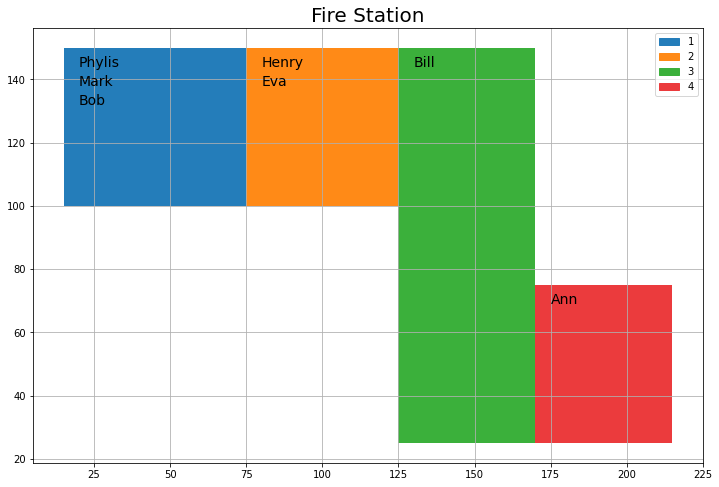

In [459]:
if solution is not None:
    rg = RoomsGraph(rooms)
    rg.setTite('Fire Station').setGrid(True).addComponents(solution)
    rg.show()
else:
    print("No solution found!")

In [406]:
# {'Phylis': 1, 'Ann': 4, 'Henry': 2, 'Eva': 2, 'Bill': 3, 'Mark': 1, 'Bob': 1}